In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Lambda, Layer, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *
from fpr_tpr_calc import *

In [2]:
#Getthe data
df_bkg = single_csv_to_df('/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/background_chan1_7.79.csv')

In [3]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [5]:
if ((len(df_bkg.columns)-5) % 2 != 0):
    num = str(int(((len(df_bkg.columns) - 5)/5) + 1))
    df_bkg['obj'+num]= -999
    df_bkg['E'+num] = -999
    df_bkg['pt'+num] = -999
    df_bkg['eta'+num] = -999
    df_bkg['phi'+num] = -999

In [6]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df_bkg.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [8]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [9]:
E = [entry for entry in df.columns if entry[0] == 'E']
pt = [entry for entry in df.columns if entry[0:2] == 'pt']
eta = [entry for entry in df.columns if entry[0:2] == 'et']
phi = [entry for entry in df.columns if entry[0:2] == 'ph']

In [10]:
np_E = np.array(df[E])
np_pt = np.array(df[pt])
np_eta = np.array(df[eta])
np_phi = np.array(df[phi])

In [12]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [13]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

In [20]:
x_val = x_train[:int(len(x_train)/3.)]
x_train = x_train[int(len(x_train)/3.):]

In [14]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (2, 2)
strides = (1, 1)
pool_size = (1, 1)

In [15]:
K.clear_session()

In [16]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon
    
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - tf.square(z_mean) - tf.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(tf.flatten(y_true), tf.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    recon_loss = tf.mean(recon_loss)
    return recon_loss
    
def my_vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = recon + kl
    return vae_loss

    
    #Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same', 
                name = 'conv_1')(x_input)
pool_1 = MaxPooling2D(pool_size = pool_size,
                          strides = 2, 
                          name = 'max_pool')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same', 
                name = 'conv_2')(pool_1)
#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)#(pool_1)
#cnn = Model(x_input, flatten, name = 'cnn')
#cnn.summary()

shape = input_shape
    
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                            activation = act_fun,
                            name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                            activation = act_fun,
                            name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
#encoder.summary()
    
#Decoding
dense_shape = shape[0]*shape[1]*shape[2]
decoder_input = keras.Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(dense_shape, 
                            activation = act_fun, 
                            name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 20,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 4, 
                             kernel_size = kernel_size, 
                             #activation = 'relu', 
                             padding = 'same', 
                             strides = strides, 
                             name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
#decoder.summary()

#outputs = decoder(encoder(x_input)[2])
#vae = Model(x_input, outputs, name = 'vae')
    
#vae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
#vae.summary()

In [17]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            reconstruction_loss *= 14*4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    #def call(self, inputs, **kwargs):
    #    return self.model(inputs, decoder)

In [18]:
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
vae = VAE(encoder, decoder)
vae.compile(optimizer = 'rmsprop')#, loss = my_vae_loss, metrics = [kl_loss, recon_loss])

In [22]:
#Fit the model
epochs = 10
batch_size = 1000

parameters = {
             'intermediate_dim' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
             'act_fun' : ['relu', 'softmax', 'sigmoid'], 
             'filters' : [16, 32, 64, 128, 256], 
             'kernel_size' : [(1,1), (2,2), (3,3)], 
             'strides' : [(1,1), (2,2), (3,3)]
             }

#vae = make_model()
#vae = KerasClassifier(build_fn=make_model, epochs = epochs, batch_size = batch_size)
#acc_scorer = make_scorer(accuracy_score)
#grid_obj = GridSearchCV(estimator=vae, param_grid=parameters, scoring=acc_scorer)
#grid_obj = grid_obj.fit(x_train, x_train)

#Set the clf to the best combination of parameters
#vae = grid_obj.best_estimator_
history_val = vae.fit(x = x_val, epochs = epochs, batch_size = batch_size, verbose = 2)

history_train = vae.fit(x = x_train, epochs = epochs, batch_size = batch_size, verbose = 2)

#vae.save('cnn-vae_model.h5')

Epoch 1/10
65/65 - 1s - loss: 40.1242 - reconstruction_loss: 36.7385 - kl_loss: 3.3857
Epoch 2/10
65/65 - 1s - loss: 27.5893 - reconstruction_loss: 26.3008 - kl_loss: 1.2885
Epoch 3/10
65/65 - 2s - loss: 22.4564 - reconstruction_loss: 21.7030 - kl_loss: 0.7534
Epoch 4/10
65/65 - 1s - loss: 24.2192 - reconstruction_loss: 23.3971 - kl_loss: 0.8220
Epoch 5/10
65/65 - 2s - loss: 29.3660 - reconstruction_loss: 28.2246 - kl_loss: 1.1414
Epoch 6/10
65/65 - 1s - loss: 22.9162 - reconstruction_loss: 22.2769 - kl_loss: 0.6393
Epoch 7/10
65/65 - 1s - loss: 29.9586 - reconstruction_loss: 28.1850 - kl_loss: 1.7736
Epoch 8/10
65/65 - 2s - loss: 24.4002 - reconstruction_loss: 23.4284 - kl_loss: 0.9718
Epoch 9/10
65/65 - 1s - loss: 24.3745 - reconstruction_loss: 23.5713 - kl_loss: 0.8032
Epoch 10/10
65/65 - 1s - loss: 21.7146 - reconstruction_loss: 21.0567 - kl_loss: 0.6580
Epoch 1/10
129/129 - 2s - loss: 22.6080 - reconstruction_loss: 21.4162 - kl_loss: 1.1918
Epoch 2/10
129/129 - 3s - loss: 20.7609 

In [118]:
#y_pred = vae.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
#ravel returns flattened array

In [117]:
_, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
y_pred = decoder.predict(z)

In [34]:
x_test_reshape = x_test.reshape(x_test.shape[0], -1)

In [35]:
x_test_df = pd.DataFrame(x_test_reshape, columns = variables)

In [36]:
x_test_E = np.array(x_test_df[E])
x_test_pt = np.array(x_test_df[pt])
x_test_phi = np.array(x_test_df[phi])
x_test_eta = np.array(x_test_df[eta])

In [19]:
y_pred_reshape = y_pred.reshape(y_pred.shape[0], -1)

In [20]:
y_pred_df = pd.DataFrame(y_pred_reshape, columns = variables)

In [21]:
y_pred_E = np.array(y_pred_df[E])
y_pred_pt = np.array(y_pred_df[pt])
y_pred_phi = np.array(y_pred_df[phi])
y_pred_eta = np.array(y_pred_df[eta])

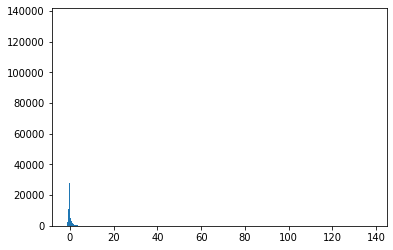

In [69]:
n, bins, patches = plt.hist(x_test_E.flatten(), 1000)

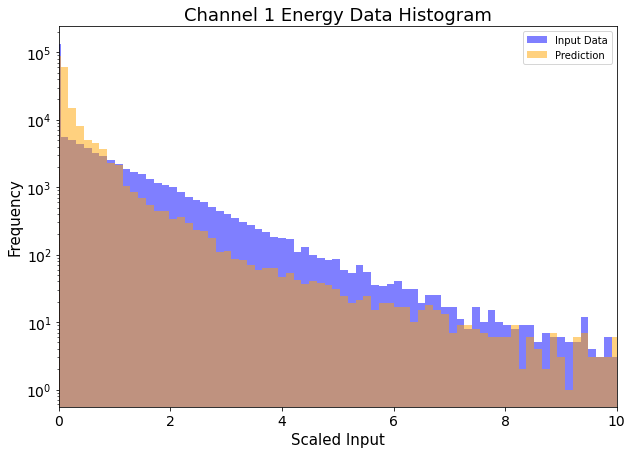

In [70]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Channel 1 Energy Data Histogram', fontsize = 18)
plt.hist(x_test_E.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_E.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

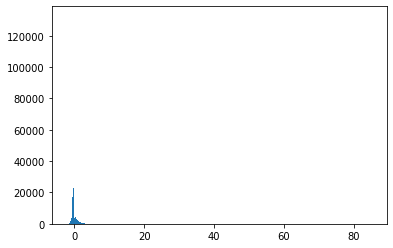

In [71]:
n, bins, patches = plt.hist(x_test_pt.flatten(), 1000)

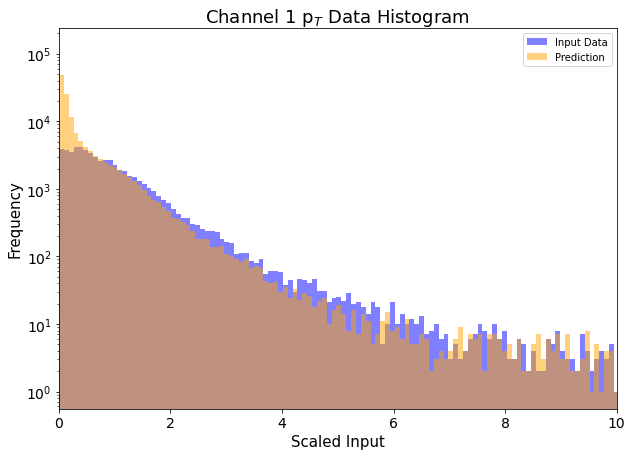

In [72]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 1 p$_T$ Data Histogram', fontsize = 18)
plt.hist(x_test_pt.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_pt.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

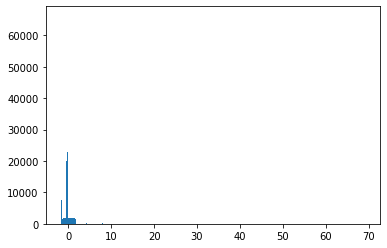

In [73]:
n, bins, patches = plt.hist(x_train_phi.flatten(), 1000)

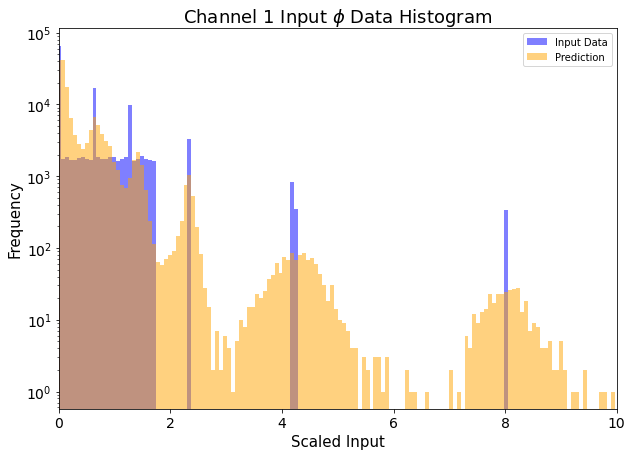

In [74]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 1 Input $\phi$ Data Histogram', fontsize = 18)
plt.hist(x_test_phi.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_phi.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

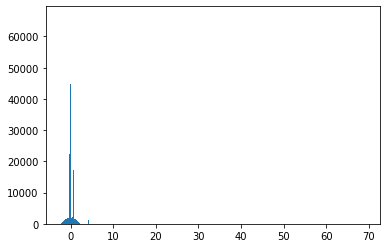

In [75]:
n, bins, patches = plt.hist(x_train_eta.flatten(), 1000)

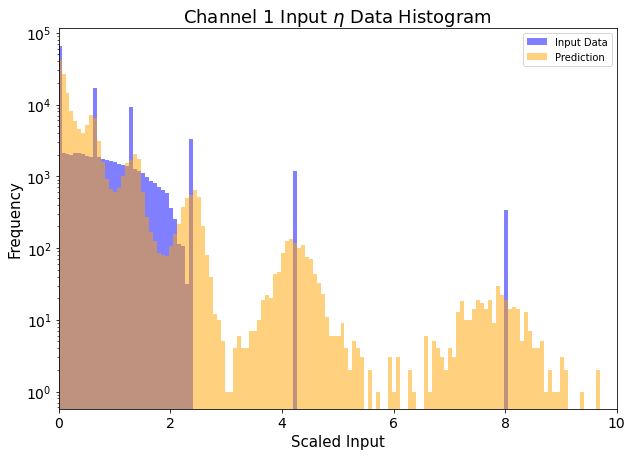

In [76]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 1 Input $\eta$ Data Histogram', fontsize = 18)
plt.hist(x_test_eta.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_eta.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

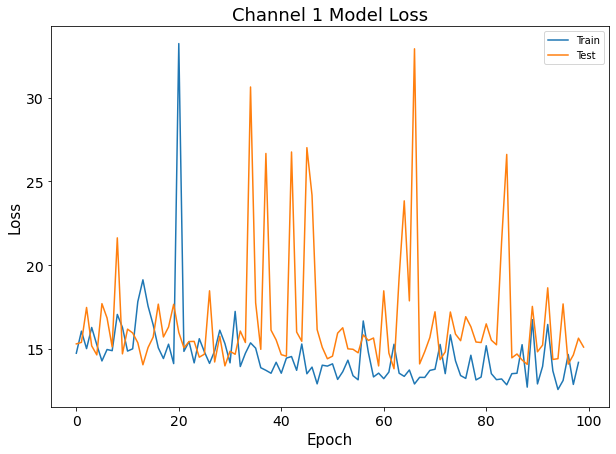

In [119]:
loss = [x for x in history_train.history['loss'] if x<100]
val_loss = [x for x in history_val.history['loss'] if x<100]
plt.figure(figsize = (10,7))
plt.plot(loss)
plt.plot(val_loss)
plt.title('Channel 1 Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc='upper left')
plt.show()

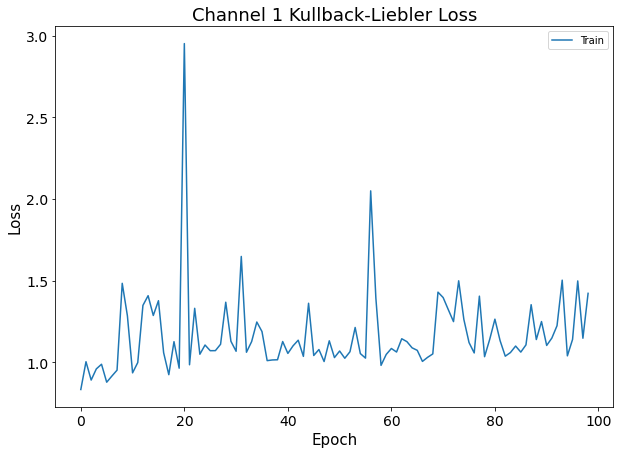

In [120]:
kl_loss = [x for x in history_train.history['kl_loss'] if x<10]
plt.figure(figsize = (10, 7))
plt.plot(kl_loss)
plt.title('Channel 1 Kullback-Liebler Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

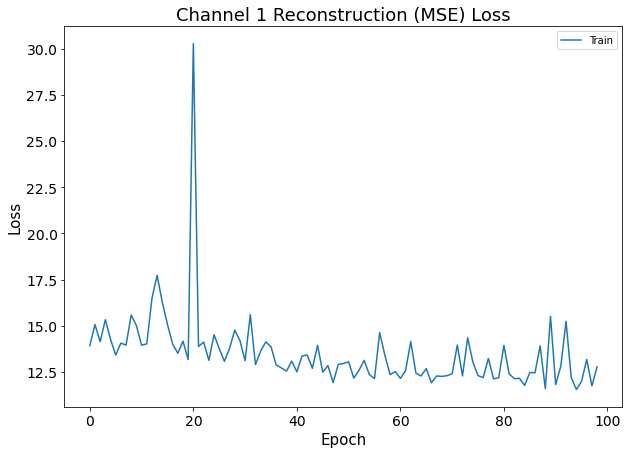

In [136]:
recon_loss = [x for x in history_train.history['reconstruction_loss'] if x<100]
plt.figure(figsize = (10, 7))
plt.plot(recon_loss)
plt.title('Channel 1 Reconstruction (MSE) Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

In [127]:
path1 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1400_neutralino1100_chan1.csv'
path2 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1600_neutralino800_chan1.csv'
path3 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/stlp_st1000_chan1.csv'
path4 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/monotop_200_A_chan1.csv'
path5 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/stop2b1000_neutralino300_chan1.csv'
path6 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/sqsq_sq1800_neut800_chan1.csv'
path7 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/sqsq1_sq1400_neut800_chan1.csv'
path8 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/monojet_Zp2000.0_DM_50.0_chan1.csv'

In [128]:
paths = [path1, path2, path3, path4, path5, path6, path7, path8]

In [133]:
fprs = []
tprs = []
for path in paths:
    df = single_csv_to_df(path)
    if (len(df)-5)%2 != 0:
        num = str(int(((len(df.columns) - 5)/5) + 1))
        df['obj'+num]= -999
        df['E'+num] = -999
        df['pt'+num] = -999
        df['eta'+num] = -999
        df['phi'+num] = -999

    if (len(df.columns)< len(df_bkg.columns)):
        diff = int(((len(df_bkg.columns)-5)/5))-int(((len(df.columns)-5)/5))
        num = int(((len(df.columns) - 5)/5) + 1)
        for i in range(diff):
            df['obj'+str(num)]= -999
            df['E'+str(num)] = -999
            df['pt'+str(num)] = -999
            df['eta'+str(num)] = -999
            df['phi'+str(num)] = -999
            num+=1
    df = df.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)


    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    _, x_test_bsm, _, y_test_bsm = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

    #x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
    x_test_bsm = x_test_bsm.reshape((x_test_bsm.shape[0], 1, -1, 4))
    _, _, z_bsm = encoder.predict(x_test_bsm.reshape(x_test_bsm.shape[0], 1, -1, 4))
    y_bsm = decoder.predict(z_bsm)
    _, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
    y_sm = decoder.predict(z)
    y_total = np.append(y_sm, y_bsm)
    y_sm = y_sm.flatten()
    y_bsm = y_bsm.flatten()
    
    
    y_true = np.append(np.zeros(len(y_sm)), np.ones(len(y_bsm)))
    y_total_norm = y_total/np.linalg.norm(y_total)
    
    fpr, tpr, _ = roc_curve(y_true, y_total_norm)
    fprs.append(fpr)
    tprs.append(tpr)

In [124]:
"""
fpr1, tpr1 = fpr_tpr_calc(path1, vae, x_test, df_bkg)
fpr2, tpr2 = fpr_tpr_calc(path2, vae, x_test, df_bkg)
fpr3, tpr3 = fpr_tpr_calc(path3, vae, x_test, df_bkg)
fpr4, tpr4 = fpr_tpr_calc(path4, vae, x_test, df_bkg)
fpr5, tpr5 = fpr_tpr_calc(path5, vae, x_test, df_bkg)
fpr6, tpr6 = fpr_tpr_calc(path6, vae, x_test, df_bkg)
fpr7, tpr7 = fpr_tpr_calc(path7, vae, x_test, df_bkg)
fpr8, tpr8 = fpr_tpr_calc(path8, vae, x_test, df_bkg)
"""

'\nfpr1, tpr1 = fpr_tpr_calc(path1, vae, x_test, df_bkg)\nfpr2, tpr2 = fpr_tpr_calc(path2, vae, x_test, df_bkg)\nfpr3, tpr3 = fpr_tpr_calc(path3, vae, x_test, df_bkg)\nfpr4, tpr4 = fpr_tpr_calc(path4, vae, x_test, df_bkg)\nfpr5, tpr5 = fpr_tpr_calc(path5, vae, x_test, df_bkg)\nfpr6, tpr6 = fpr_tpr_calc(path6, vae, x_test, df_bkg)\nfpr7, tpr7 = fpr_tpr_calc(path7, vae, x_test, df_bkg)\nfpr8, tpr8 = fpr_tpr_calc(path8, vae, x_test, df_bkg)\n'

In [134]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime']
#fprs = [fpr1, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7, fpr8]
#tprs = [tpr1, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7, tpr8]
signals = ['glgl1400_neutralino1100', 
           'glgl1600_neutralino800', 
           'stlp_st1000', 
           'monotop_200_A',
           'stop2b1000', 
           'sqsq_sq1800_neut800', 
           'sqsq1_sq1400', 
           'monojet_Zp2000.0_DM_50.0']

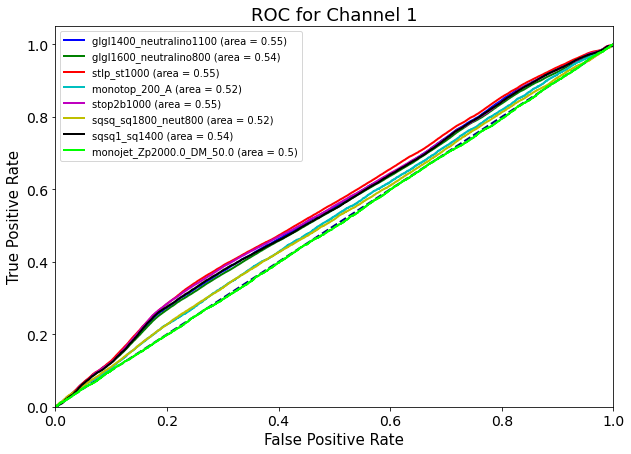

In [137]:
lw = 2
plt.figure(figsize = (10, 7))
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0, 1.05])
plt.title('ROC for Channel 1', fontsize = 18)
for fpr, tpr, sig, col in zip(fprs, tprs, signals, colours):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = col, lw = lw, 
             label = '{} (area = {})'.format(sig, round(roc_auc, 2)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
from performance import *

In [ ]:
y_pred = y_pred.flatten()

In [ ]:
AUC = []
epsilon1 = []
epsilon2 = []
epsilon3 = []

In [ ]:
for i in paths:
    df_sig = single_csv_to_df(path1)
    if ((len(df_sig.columns)-5) % 2 != 0):
        num = str(int(((len(df_sig.columns) - 5)/5) + 1))
        df_sig['obj'+num]= -999
        df_sig['E'+num] = -999
        df_sig['pt'+num] = -999
        df_sig['eta'+num] = -999
        df_sig['phi'+num] = -999
    
    df = df_sig.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    #Now we one_hot encode the data to make sure we have a class definition
    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)

    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                        df[processes].values, 
                                                        shuffle = True,
                                                        random_state = 42,
                                                        test_size = 0.1)
    x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

    y_pred_sig = vae.predict(x_test)
    y_pred_sig = y_pred_sig.flatten()

    auc, ep1, ep2, ep3 = performance(y_pred, y_pred_sig)

    AUC.append(auc)
    epsilon1.append(ep1)
    epsilon2.append(ep2)
    epsilon3.append(ep3)

In [ ]:
AUC

In [ ]:
epsilon1

In [ ]:
epsilon2

In [ ]:
epsilon3